<a href="https://colab.research.google.com/github/luisdiaz1997/Python-Lessons/blob/master/CSC821_Lec9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://i.stack.imgur.com/eoKv4.jpg -O rice.jpg

--2020-04-14 14:14:37--  https://i.stack.imgur.com/eoKv4.jpg
Resolving i.stack.imgur.com (i.stack.imgur.com)... 104.16.1.35, 104.16.3.35, 104.16.2.35, ...
Connecting to i.stack.imgur.com (i.stack.imgur.com)|104.16.1.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102243 (100K) [image/jpeg]
Saving to: ‘rice.jpg’

rice.jpg            100%[===================>]  99.85K  --.-KB/s    in 0.02s   

2020-04-14 14:14:37 (6.32 MB/s) - ‘rice.jpg’ saved [102243/102243]



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [0]:
im = imageio.imread('rice.jpg', pilmode = 'L')
print('shape:', im.shape,', Min value = ', im.min(), ', Max value = ', im.max())

shape: (450, 450) , Min value =  38 , Max value =  207


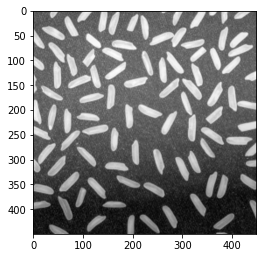

In [0]:
plt.figure(1, figsize= (4, 6))
plt.imshow(im, cmap = 'gray')

In [0]:
def apply_threshold(im, value):
  t_im = np.zeros(im.shape)
  t_im[im >= value] = 1
  return t_im

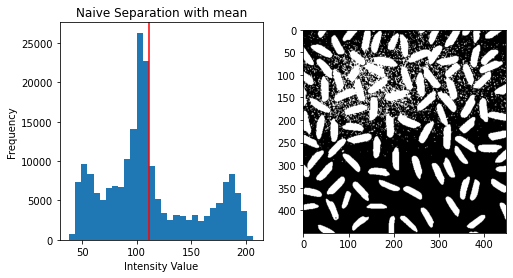

In [0]:
plt.figure(2, figsize = (8, 4))
plt.subplot(121)
plt.hist(im.reshape(-1), 30)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.title('Naive Separation with mean')
plt.axvline(x = im.mean(), color = 'r')

plt.subplot(122)
plt.imshow(apply_threshold(im, im.mean()), cmap = 'gray');


In [0]:
def basic_threshold(im, steps =10, debug = False):
  T = im.mean()
  for i in range(steps):
    U1 = im[im<T].mean()
    U2 = im[im>=T].mean()
    T = (U1 + U2)/2
    if debug: print(T)

  return T

In [0]:
basic_threshold(im, steps = 10, debug = True) #We see how it converges after 4 iterations

121.76888132016558
128.29979454457984
130.41606172070823
130.95502028328394
130.95502028328394
130.95502028328394
130.95502028328394
130.95502028328394
130.95502028328394
130.95502028328394


130.95502028328394

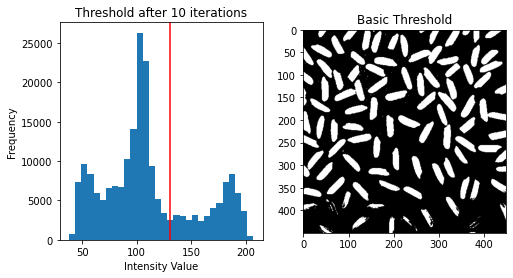

In [0]:
plt.figure(3, figsize = (8, 4))
plt.subplot(121)
plt.hist(im.reshape(-1), 30)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.title('Threshold after 10 iterations')

T = basic_threshold(im)
plt.axvline(x = T, color = 'r')

plt.subplot(122)
plt.title('Basic Threshold')
plt.imshow(apply_threshold(im, T), cmap = 'gray');

In [0]:
def outer_variance(im, T):
  n1 = im[im<T].sum() 
  n2 = im[im>= T].sum()
  if (n1 == 0 or n2 == 0):
    return 0
  U1 = im[im<T].mean()
  U2 = im[im>=T].mean()

  return (n1 * n2) * ((U1-U2)**2)

In [0]:
def optimal_threshold(im):
  all_T = np.arange(0, 256, 1)
  values = np.array([outer_variance(im, T) for T in all_T])
  return values.argmax()


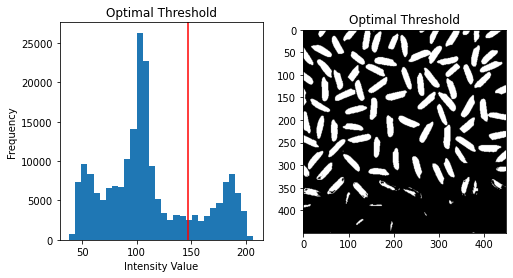

In [0]:
plt.figure(4, figsize = (8, 4))
plt.subplot(121)
plt.hist(im.reshape(-1), 30)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.title('Optimal Threshold')

T = optimal_threshold(im)
plt.axvline(x = T, color = 'r')

plt.subplot(122)
plt.title('Optimal Threshold')
plt.imshow(apply_threshold(im, T), cmap = 'gray');

In [0]:
def partition_image(im, regions = 4):
  x_len = im.shape[0]//regions
  y_len = im.shape[1]//regions
  for i in range(regions):
    for j in range(regions):
      if (i == regions-1) and (i == j):
        yield im[y_len*i:,  x_len*j: ]
        continue
      yield im[y_len*i:y_len*(i+1),  x_len*j: x_len*(j+1)]


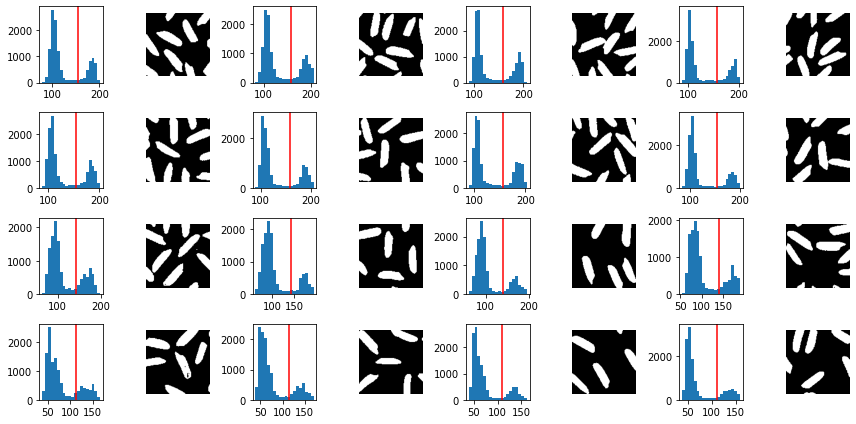

In [0]:
plt.figure(5, figsize = (12, 6))
regions = 4
im_generator = partition_image(im, regions = regions)
for i in range((regions**2)):

  curr_im = next(im_generator)
  T = optimal_threshold(curr_im)

  plt.subplot(regions,regions*2, 2*i + 1)
  plt.hist(curr_im.reshape(-1), 20)
  plt.axvline(x = T, color = 'r')

  plt.subplot(regions,regions*2, 2*i + 2)
  plt.imshow(apply_threshold(curr_im, T), cmap = 'gray')
  plt.axis('off');
plt.tight_layout()

In [0]:
def niblack(im, k = -0.5):
  assert (k <= 0 and k>= -1), "k should be between 0 and -1"
  T = im.mean() + k*np.std(im)
  return T

In [0]:
def adaptive_threshold(im, regions = 4):
  im_generator = partition_image(im, regions = regions)
  t_im = np.zeros(im.shape)

  x_len = im.shape[0]//regions
  y_len = im.shape[1]//regions
  for i in range(regions):
    for j in range(regions):
      curr_im = next(im_generator)
      T = niblack(curr_im, k = 0)

      if (i == regions-1) and (i == j):
        t_im[y_len*i:,  x_len*j: ] = apply_threshold(curr_im, T)
        continue
      
      t_im[y_len*i:y_len*(i+1),  x_len*j: x_len*(j+1)] = apply_threshold(curr_im, T)
  return t_im

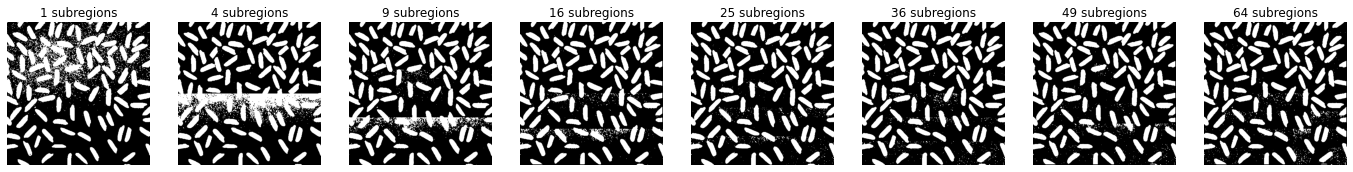

In [0]:
plt.figure(6, figsize = (8 *3, 3))
for i in range(8):
  plt.subplot(1, 8, i+1)
  plt.imshow(adaptive_threshold(im, regions = i+1), cmap = 'gray')
  plt.title(str((i+1)**2) + ' subregions')
  plt.axis('off')

In [0]:
def get_grid(im):
  M = np.mgrid[0:im.shape[0], 0:im.shape[1]]
  return np.transpose(M, axes = (1, 2, 0))

In [0]:
def add_polynomials(x, order = 5):
    
    x_new = list()
    for i in range(1, order+1):
        for j in range(i+1):
            x_new.append((x[:,0]** (i-j)) *(x[:,1]** (j))) 
    x_new = np.array(x_new)
    
    
    return x_new.T

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
def fit_surface(im, order = 3):
  M = get_grid(im)
  A = add_polynomials(M.reshape(-1, 2), order = order)
  '''
  b = np.dot(np.dot(np.linalg.pinv(np.dot(A.T, A)), A.T), im.reshape(-1, 1))
  D = np.dot(A, b).reshape(im.shape)
  '''
  
  reg = LinearRegression().fit(A, im.reshape(-1, 1)) #Used Sklearn regression since it uses gradient descent
  D = reg.predict(A)                                 #More stable than pseudoinverse
  D = D.reshape(im.shape)
  
  return D

In [0]:
def fit_surface_iterative(im, order =3, steps = 5):
  M = im
  for i in range(steps):
    M = M - fit_surface(M, order = order)
  return M

In [0]:
D = fit_surface_iterative(im, order =3, steps = 5)

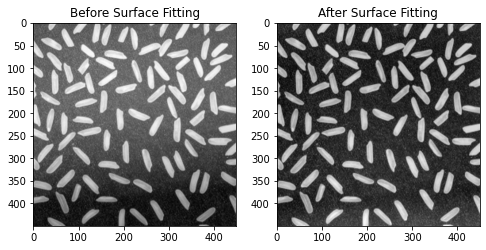

In [27]:
plt.figure(7, figsize = (8, 4))
plt.subplot(121)
plt.title('Before Surface Fitting')
plt.imshow(im, cmap = 'gray')

plt.subplot(122)
plt.title('After Surface Fitting')
plt.imshow(D, cmap = 'gray');

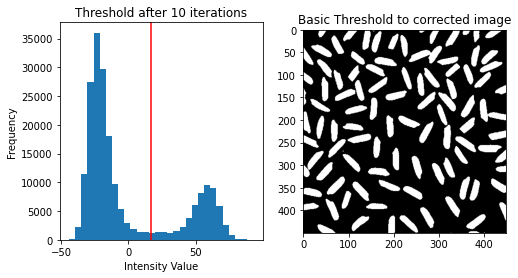

In [28]:
plt.figure(8, figsize = (8, 4))
plt.subplot(121)
plt.hist(D.reshape(-1), 30)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.title('Threshold after 10 iterations')

T = basic_threshold(D)
plt.axvline(x = T, color = 'r')

plt.subplot(122)
plt.title('Basic Threshold to corrected image')
plt.imshow(apply_threshold(D, T), cmap = 'gray');